In [1]:
import plotly
import librosa

import tensorflow        as tf
import numpy             as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline    as py

from librosa                     import display
from scipy.io                    import wavfile
from scipy                       import signal
from tensorflow.python.framework import ops

import os
from random import shuffle

In [2]:
#plotly.__version__

In [3]:
py.init_notebook_mode(connected=True)

In [4]:
y, sr = librosa.load('../data/speech_commands/happy/3ab9ba07_nohash_0.wav', sr=8000)

In [5]:
mel = librosa.feature.melspectrogram(y=y, sr=sr)

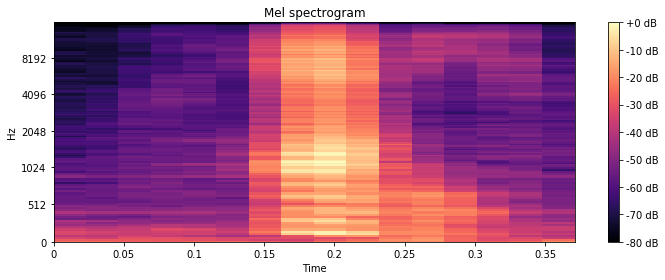

In [6]:
plt.figure(figsize=(10, 4))

librosa.display.specshow(librosa.power_to_db(mel,
                                             ref=np.max),
                                             y_axis='mel', fmax=16000,
                                             x_axis='time')

plt.colorbar    (format='%+2.0f dB')
plt.title       ('Mel spectrogram')
plt.tight_layout()

In [7]:
np.shape(mel)

(128, 16)

In [8]:
mfcc = librosa.feature.mfcc(y=y, sr=sr)

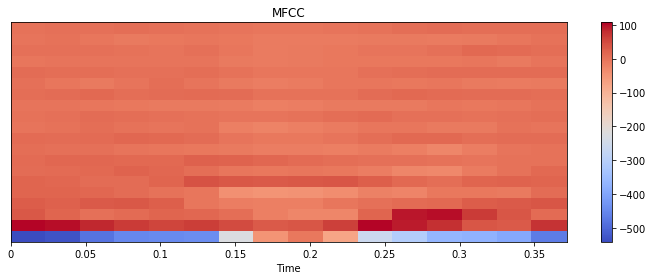

In [9]:
plt.figure(figsize=(10, 4))

librosa.display.specshow(mfcc, x_axis='time')

plt.colorbar    ()
plt.title       ('MFCC')
plt.tight_layout()

In [10]:
def log_specgram(path, window_size=20, step_size=10, eps=1e-10):
    sample_rate, audio = wavfile.read(path)
    
    nperseg  = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size   * sample_rate / 1e3))
    
    freqs, times, spec = signal.spectrogram(audio,
                                    fs       = sample_rate,
                                    window   = 'hann'     ,
                                    nperseg  = nperseg    ,
                                    noverlap = noverlap   ,
                                    detrend  = False       )
    
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [11]:
freqs, times, spectrogram = log_specgram('../data/speech_commands/happy/3ab9ba07_nohash_0.wav')

In [12]:
data   = [go.Surface(z=spectrogram.T)]
layout = go.Layout(
    title = 'Specgtrogram of "yes" in 3d',
    scene = dict(
    yaxis = dict(title='Frequencies'   , range=freqs),
    xaxis = dict(title='Time'          , range=times),
    zaxis = dict(title='Log amplitude'              ),
    ),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [13]:
mel_min = min(mel.min(axis=0))
print(mel_min)

1.4123496134186506e-08


In [14]:
mel_max = max(mel.max(axis=0))
print(mel_max)

30.80978601469951


In [15]:
mel_norm = (mel - mel_min) / (mel_max - mel_min)

In [16]:
mel_norm

array([[3.23547886e-03, 2.94700592e-03, 2.08757182e-03, ...,
        1.94911592e-03, 2.40317873e-03, 1.11752733e-02],
       [1.60782750e-03, 1.53103208e-03, 1.46772488e-03, ...,
        7.01842656e-04, 9.78887765e-04, 3.17163553e-03],
       [4.32977655e-04, 3.02746767e-04, 9.19992120e-04, ...,
        5.55363751e-04, 5.76764986e-04, 2.12940642e-04],
       ...,
       [1.34006077e-08, 1.18917158e-08, 3.55398338e-08, ...,
        4.60251749e-06, 2.14530784e-06, 9.56330846e-08],
       [9.44300510e-09, 3.36438577e-09, 9.17388633e-09, ...,
        8.79828077e-07, 5.17864056e-07, 2.71634371e-08],
       [8.86876645e-09, 1.98714056e-09, 9.18070495e-11, ...,
        1.92097228e-08, 9.11979919e-09, 0.00000000e+00]])

In [17]:
norm_min = min(mel_norm.min(axis=0))
print(norm_min)

norm_max = max(mel_norm.max(axis=0))
print(norm_max)

0.0
1.0


In [18]:
class Training_Example:
    def __init__(self, mel, label):
        self.mel   = mel
        self.label = label

In [19]:
def load_data_set(path):
    training_examples = []
    test_examples     = []
    
    count = 0
    for directory in os.listdir(path):
        label = directory
        
        if os.path.isdir(path + '/' + directory) and directory != '_background_noise_':
            num_examples = 0
            for wavFile in os.listdir(path + '/' + directory):
                y, sr = librosa.load(path + '/' + directory + '/' + wavFile, sr=8000)
                
                if y.shape[0] != sr:
                    y = np.append(y, [0] * (sr - len(y)))
                
                mel   = librosa.feature.melspectrogram(y=y, sr=sr)
                
                mel_min = min(mel.min(axis=0))
                mel_max = max(mel.max(axis=0))
                
                denom = mel_max - mel_min
                if denom == 0.0 or np.isnan(denom):
                    continue
                
                mel_norm = (mel - mel_min) / (mel_max - mel_min)
                
                mel_norm = np.expand_dims(mel_norm, axis=-1)
                
                example = Training_Example(mel_norm, np.eye(30)[count])
                
                num_examples += 1
                
                if num_examples < 2200:
                    training_examples.append(example)
                else:
                    test_examples.append(example)
            
            count += 1
            print(directory + ': ' + str(num_examples))
            
    return training_examples, test_examples, count

In [20]:
training_examples, test_examples, num_labels = load_data_set('../data/speech_commands')

bed: 1713
bird: 1730
cat: 1733
dog: 1746
down: 2359
eight: 2352
five: 2357
four: 2372
go: 2372
happy: 1742
house: 1750
left: 2353
marvin: 1746
nine: 2364
no: 2375
off: 2357
on: 2367
one: 2370
right: 2367
seven: 2377
sheila: 1734
six: 2369
stop: 2380
three: 2356
tree: 1733
two: 2373
up: 2375
wow: 1745
yes: 2377
zero: 2376


In [21]:
print(len(training_examples))
print(len(test_examples    ))

61352
3368


In [22]:
def getBatch(examples, batch, batch_size):
    start = batch       * batch_size
    end   = (batch + 1) * batch_size
    
    freqs  = []
    labels = []
    
    if end >= len(examples):
        end = len(examples)
    
    for i in range(start, end):
        freqs.append(examples [i].mel  )
        labels.append(examples[i].label)
    
    return freqs, labels

In [25]:
def simple_training_model(training_examples, numCategories, learning_rate = 1e-5, num_epochs = 5, batch_size = 32):
    ops.reset_default_graph()
    m = len(training_examples)
    
    model_input  = tf.placeholder(dtype = tf.float32, shape = (None, 128, 16, 1),    name = 'mel_input'   )
    labels       = tf.placeholder(dtype = tf.float32, shape = (None, numCategories), name = 'labels'      )
    is_training  = tf.placeholder(dtype = tf.bool,                                   name = 'is_training' )
    
    with tf.device('gpu:0'):
        output = tf.layers.conv2d       (model_input, filters=64, kernel_size=(7, 3), padding='SAME', activation=tf.nn.elu)
        output = tf.layers.max_pooling2d(output, pool_size=(1, 3), strides=(1,1),     padding='SAME')
        
        output = tf.layers.conv2d       (output,      filters=128, kernel_size=(1, 7), padding='SAME', activation=tf.nn.elu)
        output = tf.layers.max_pooling2d(output, pool_size=(1, 4), strides=(1,1),      padding='SAME')
        
        output = tf.layers.conv2d       (output,      filters=128, kernel_size=(1, 7), padding='SAME', activation=tf.nn.elu)
        output = tf.layers.max_pooling2d(output, pool_size=(1, 4), strides=(1,1),      padding='SAME')
        
        output = tf.layers.conv2d       (output,      filters=256, kernel_size=(1, 10), padding='VALID', activation=tf.nn.elu)
        output = tf.layers.conv2d       (output,      filters=512, kernel_size=(1, 2), activation=tf.nn.elu)
        
        output         = tf.layers.flatten(output)
        output         = tf.layers.dropout(output, training=is_training)
        output         = tf.layers.dense  (output, numCategories, activation=tf.identity)
        output = tf.cond(is_training, lambda: output, lambda: tf.nn.softmax(output, name='final_output'))
        
        #cost      = tf.reduce_mean(tf.abs(labels - softmax_output))
        cost = tf.losses.softmax_cross_entropy(onehot_labels=labels, logits=output)
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
        
    saver = tf.train.Saver()
    
    init  = tf.global_variables_initializer()

    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
    sess.run(init)
    
    tf.train.write_graph(sess.graph.as_graph_def(), './tmp/input_model', 'input_word_recognition.pbtxt', True)

    for epoch in range(num_epochs):
        epoch_cost = 0
        num_batches = (int)(m / batch_size)
        
        shuffle(training_examples)
        for batch in range(num_batches):
            freqs, l   = getBatch(training_examples, batch, batch_size)
            
            _, batch_cost = sess.run([optimizer, cost], feed_dict = { model_input : freqs, labels : l, is_training : True})
            epoch_cost += batch_cost / num_batches
    
        if epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            print ()
            print ("---------------------------------------------")
            print ()
            saver.save(sess, './tmp_' + str(epoch) + '/word_recognition.ckpt')
            
    print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
    print ()
    print ("---------------------------------------------")
    print ()
    saver.save(sess, './tmp_final/word_recognition.ckpt')

In [26]:
simple_training_model(training_examples, numCategories = num_labels, num_epochs=100, batch_size = 16)

Cost after epoch 0: 2.465342

---------------------------------------------

Cost after epoch 10: 1.087810

---------------------------------------------

Cost after epoch 20: 0.817455

---------------------------------------------

Cost after epoch 30: 0.605677

---------------------------------------------

Cost after epoch 40: 0.432543

---------------------------------------------

Cost after epoch 50: 0.285958

---------------------------------------------

Cost after epoch 60: 0.178562

---------------------------------------------

Cost after epoch 70: 0.106336

---------------------------------------------

Cost after epoch 80: 0.067494

---------------------------------------------

Cost after epoch 90: 0.045021

---------------------------------------------

Cost after epoch 99: 0.034604

---------------------------------------------



In [100]:
ops.reset_default_graph()

with tf.device(':cpu0'):
    model_input = np.random.rand(2, 128, 16, 1)
    model_input = tf.cast(model_input, tf.float32)
    
    output = tf.layers.conv2d       (model_input, filters=64, kernel_size=(7, 3), padding='SAME', activation=tf.nn.elu)
    output = tf.layers.max_pooling2d(output, pool_size=(1, 3), strides=(1,1))
    
    output = tf.layers.conv2d       (output, filters=128, kernel_size=(1, 7), padding='SAME', activation=tf.nn.elu)
    output = tf.layers.max_pooling2d(output, pool_size=(1, 4), strides=(1,1))
    
    output = tf.layers.conv2d       (output, filters=256, kernel_size=(1, 10), padding='VALID', activation=tf.nn.elu)
    output = tf.layers.conv2d       (output, filters=512, kernel_size=(1, 2), activation=tf.nn.elu)
    
    output = tf.layers.flatten(output)
    output = tf.layers.dropout(output)
    output = tf.layers.dense  (output, 5000)
    output = tf.layers.dropout(output)
    output = tf.layers.dense  (output, 11)
    softmax_output  = tf.nn.softmax  (output)
    
    

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
o = sess.run(output)

print(np.shape(o))

(2, 11)


In [86]:
index = 3

ops.reset_default_graph()

training_example = training_examples[index]
test_input = training_example.mel

test_input = np.reshape(test_input, (1, 128, 16, 1))
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./tmp_final/word_recognition.ckpt.meta')
    saver.restore(sess, './tmp_final/word_recognition.ckpt')
    graph = tf.get_default_graph()
    out = graph.get_tensor_by_name('final_output:0')
    
    encoding = sess.run(out, feed_dict = { 'mel_input:0' : test_input, 'is_training:0' : False })
    
sencoding = encoding[0]
print(np.where(sencoding              == np.amax(sencoding))[0][0])
print(np.where(training_example.label == np.amax(training_example.label))[0][0])


INFO:tensorflow:Restoring parameters from ./tmp_final/word_recognition.ckpt
26
26


In [27]:
def getAccuracy(examples):
    correct   = 0
    incorrect = 0
    
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph('./tmp_final/word_recognition.ckpt.meta')
        saver.restore(sess, './tmp_final/word_recognition.ckpt')
        graph = tf.get_default_graph()
        out = graph.get_tensor_by_name('final_output:0')
        
        for example in examples:
            test_input = example.mel
            test_input = np.reshape(test_input, (1, 128, 16, 1))
            
            encoding = sess.run(out, feed_dict = { 'mel_input:0' : test_input, 'is_training:0' : False })
            
            sencoding = encoding[0]
            
            guess = np.where(sencoding              == np.amax(sencoding))[0][0]
            actual= np.where(training_example.label == np.amax(training_example.label))[0][0]
            
            if guess == actual:
                correct += 1
            else:
                incorrect += 1
                
    accuracy = correct / (correct + incorrect)
    print(accuracy)

In [29]:
getAccuracy(training_examples)

INFO:tensorflow:Restoring parameters from ./tmp_final/word_recognition.ckpt


KeyError: "The name 'final_output:0' refers to a Tensor which does not exist. The operation, 'final_output', does not exist in the graph."

In [91]:
getAccuracy(test_examples)

61367